In [50]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import os
from collections import Counter
from IPython.display import Latex, Image
from datetime import datetime

# All the data are from Google's BigQuery Open Dataset
# So you need to get the sign in credentials for Google Cloud
# WARNING. Querying through Google Cloud is not FREE. 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath("./login.json")

# Summary
_The experience with JavaScript, the primary programming language for front end development, is not pleasant. There are too many choices doing the same thing, while they have their own implementations that are not compatible with each other. Further more, the many frameworks vary so much in syntax, while similar in functionality. I've also seen similar voice on Quora, Reddit, and Medium._

_This poster is targeted at the web developers. I want to find clues to show that the WebDev community is suffering from these unnecessary redundancy. Therefore, the developers can think about how to improve the community by building better standards and stop writing inefficient code._

# Part I. A Glance of the Data

The data is found from Libraries.io, who tracks 37 package managers and 3 open source repository platforms. Near 5 million projects and repositories are collected, and their dependencies were tracked between 2015 and 2018.

This dataset is quite sophisticated, it includes the primary language of the project, the number of dependent projects, as well as the keywords and description. These information is extremely useful for my purpose. As most web projects are developed in primarily JavaScript and its derivatives, I can filter out web projects by the language. Also, I can use the keywords and description to determine the general purpose of the project. 

On the other side, not every project will grow to be a good project. Most of the projects are in low-quality and/or abandoned by the project owner. Libraries.io proposes one metric, the SourceRank, to measure the quality of the project. SourceRank is primarily determined by the number of dependent projects, the last update date, and the quality of the documentation. I dropped all projects that is lower or equal to 5 SourceRank score, which are mostly sketchy projects without any documentation and not updated for quite a long time. 

In [16]:
###
# All the queries are commented out to save money for from Google Database
# All the querying results will be saved in ./data/
###


# intro = pd.read_gbq(
#     """
#     SELECT name, created_timestamp as created, 
#        updated_timestamp as updated, 
#        description,
#        keywords,
#        sourcerank,
#        dependent_projects_count,
#        language
#     FROM `bigquery-public-data.libraries_io.projects` 
#     ORDER BY sourcerank DESC
#     LIMIT 20
#     """
# )
# intro.to_csv("./data/intro.csv", index=False);


# dep_intro = pd.read_gbq(
#     """
#     SELECT project_name, 
#        dependency_name, 
#        dependency_project_id,
#     FROM `bigquery-public-data.libraries_io.dependencies` as dep 
#         JOIN `bigquery-public-data.libraries_io.projects` as proj ON dep.project_id = proj.id
#     GROUP BY project_name, dependency_name, dependency_project_id
#     ORDER BY MAX(sourcerank) DESC
#     LIMIT 20"""
# )

# dep_intro.to_csv("./data/dep_intro.csv", index=False)

In [63]:
intro = pd.read_csv("./data/intro.csv")
intro.created = pd.to_datetime(intro.created).apply(lambda x: x.strftime("%Y-%m-%d"))
intro.updated = pd.to_datetime(intro.updated).apply(lambda x: x.strftime("%Y-%m-%d"))
intro.keywords = intro.keywords.apply(lambda x: ", ".join(str(x).replace("nan", "").split(",")[:3]))
display(intro)

,name,created,updated,description,keywords,sourcerank,dependent_projects_count,language
0,react,2015-01-29,2018-12-22,React is a JavaScript library for building use...,react,34,62071,JavaScript
1,react-dom,2015-01-29,2018-12-20,React package for working with the DOM.,react,33,48287,JavaScript
2,lodash,2015-01-28,2018-12-21,Lodash modular utilities.,"modules, stdlib, util",33,78302,JavaScript
3,webpack,2015-01-29,2018-12-22,Packs CommonJs/AMD modules for the browser. Al...,,33,82495,JavaScript
4,typescript,2015-01-29,2018-12-22,TypeScript is a language for application scale...,"TypeScript, Microsoft, compiler",33,66445,TypeScript
5,babel-core,2015-02-15,2018-12-19,Babel compiler core.,"6to5, babel, classes",32,95760,JavaScript
6,eslint,2015-01-27,2018-12-19,An AST-based pattern checker for JavaScript.,"ast, lint, javascript",32,124191,JavaScript
7,@types/node,2016-05-25,2018-12-19,TypeScript definitions for Node.js,,31,39746,TypeScript
8,jest,2015-01-29,2018-12-19,Delightful JavaScript Testing.,"ava, babel, coverage",31,47512,JavaScript
9,babel-loader,2015-02-15,2018-10-27,babel module loader for webpack,"webpack, loader, babel",31,62716,JavaScript


In [62]:
dep_intro = pd.read_csv("./data/dep_intro.csv")
display(dep_intro)

,project_name,dependency_name,dependency_project_id
0,react,envify,144990
1,react,promised-io,302230
2,react,fbjs,823625
3,react,tap,321029
4,react,eventemitter2,145666
5,react,tapr,321108
6,react,sprint,316921
7,react,scheduler,310860
8,react,Deferred,277390
9,react,loose-envify,986741


#  2. Think About the Story

Looking at the huge data, I spent a long time determining what should be put on a poster. Considering the audience, who should be developers or the public without deep understanding with statistics. I decided to make the story visually appealing and simple in concepts. 

##  2.1 WebDev is Complicated
The thought is very natural, to show the size of WebDev community and to show the complexity of working on these projects. 

### 2.1.1 Web world is Huge 
The first thing to show is that JavaScript dominates in number of projects. Although developers know that JavaScript has the largest community among all languages, most people may not understand how dominant it is. I want my audience to have a very direct view on the size.

### 2.1.2. Web world is Messy
I proposed several measures for "complexity" of a language. For example, I tried the depth of the dependency tree. However, I found most of the measurements are not easy to understand or it is not significant enough for the comparisons between JavaScript and other languages. I finally choose to use the average number of dependencies. This measurement is simple and JavaScript clearly beats others. 

## 2.2 Redundancy
This is a very hard measurement. The initial idea is to build community graph from dependencies and then measure how similar their distribution over keywords are. However, I quickly faced many issue with this approach. First, the size of the dataset is still too large to construct a the dependency graph. Second, the concept is too complex to explain these in a poster.   

### 2.2.1. Redundancy in Simple Tasks
I worked around by "attacking" JavaScript's own historical problem. Because JavaScript is not a well-designed language, it lacks a lot of standard libraries for simple tasks, hence the community build packages fill in. However, due to the lack of communication, many community packages work on the same problem and are incompatible with each other. Such problems have troubled me a lot, and I've seen many memes on the issues. Therefore, I used the same approach by showing how JavaScript have redundant packages on the simple tasks. 

### 2.2.2. Redundancy in Frameworks
Finally, I looked at the redundancy over frameworks. There are so many question on the Internet about which framework should web developers choose, while they don't show much difference over these packages. I decided to leave this topic as the final thoughts. These frameworks are leading ways for nowadays web development. However, do the webdev community need these many of frameworks on the same thing. 

# 3. Designing Process
## 3.1  The Layout

The design is more for the flow of the story, and the actual content I want to fit. The first design (left) put more weights on the "redundancy" part, while I realized that the first part is too crowded and the two parts should be equally important. In addition, the four parts grid fits my story better. 


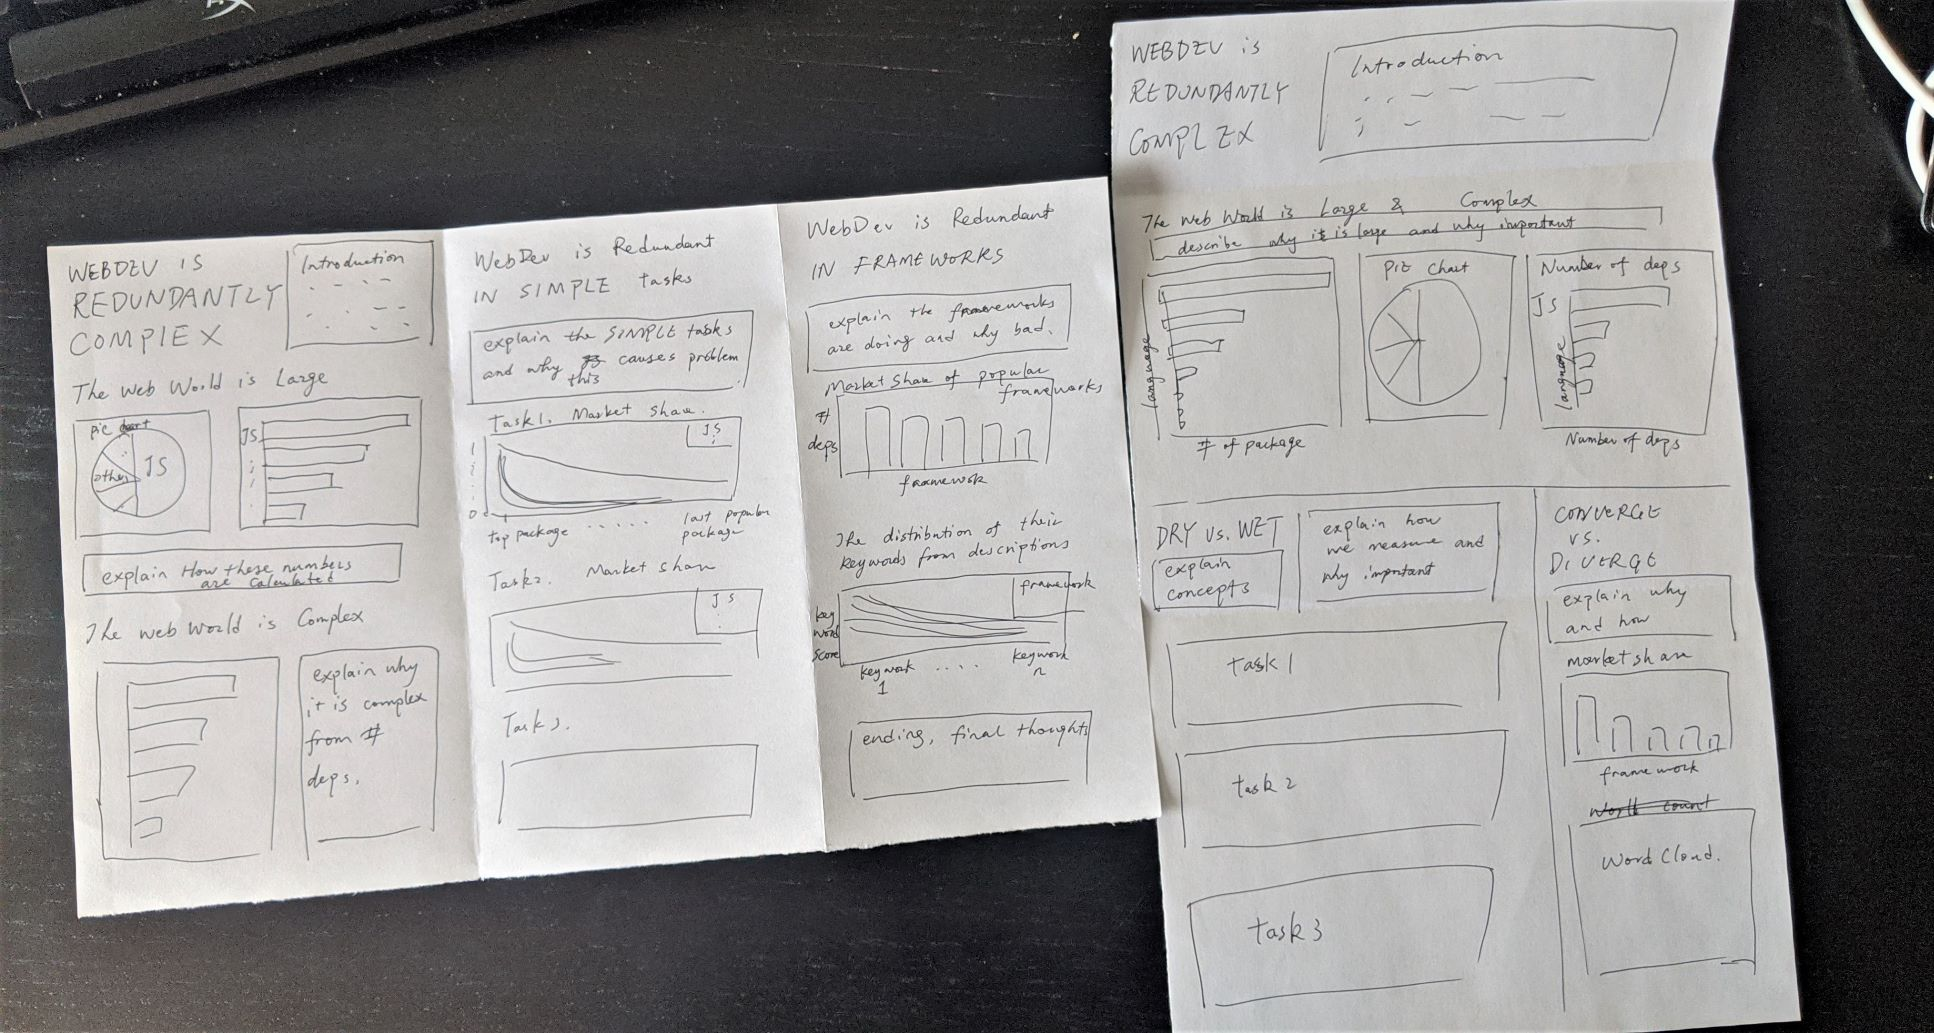

In [54]:
display(Image("./plots/layout.jpg"))

## 3.2 The Plots

Many decisions are made on the plots. For showing the WebDev world is huge. I tried to use a bar plot and a pie chart to show the number of projects in JavaScript and the market share it has. However, I find that the two plots have the same information. Therefore, I tried to plot the number of new projects in each language through time as a stacked bar plot, while it has too much information and does not convey the message well. Finally, I choose to have the line plot of the cumulative number of projects for each language, along with the market share as a bar. 

For the redundancy part, I tried to balance between the amount of data manipulation and the intuition. I've thought about using the distribution of keywords. However, the information is not quite clear for the audience, and overall looks messy. Finally, I focused more on the intuition side. The plots I used are not "friendly" for statisticians and they don't have quite the exact information (circles, colors). However, they are more visually appealing for the public and allow the audience to consider more on the message. 

In [20]:
# time_proj = pd.read_gbq(
#     """
#     SELECT TIMESTAMP_TRUNC(created_timestamp, MONTH) as time, language, COUNT(id) as number
#     FROM `bigquery-public-data.libraries_io.projects`
#     WHERE sourcerank > 5
#     GROUP BY language, time
#     """
# )
# time_proj.to_csv("./data/time_proj.csv", index=False)

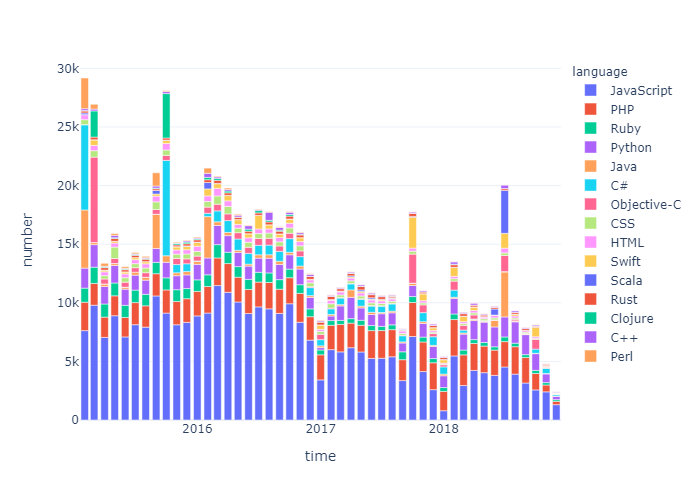

In [55]:
# Combine JS with all its derivatives 
JS_based = ['JavaScript', 'CoffeeScript', 'TypeScript', 'Vue']
time_proj = pd.read_csv("./data/time_proj.csv").dropna()
time_proj = time_proj.loc[time_proj.language != "Go"]
time_proj = time_proj.dropna()
time_dict = {}
def remove_js_based(row):
    if row['language'] in JS_based:
        time_dict[row['time']] = row['number'] + time_dict.get(row['time'], 0)
        return None
    return row
time_proj = time_proj.apply(remove_js_based, axis=1)
js_df = pd.DataFrame({'time': list(time_dict.keys()), 
                      'number': list(time_dict.values()), 
                      'language': ['JavaScript'] * len(time_dict.keys())})
time_proj = time_proj.append(js_df)

# Plot the number of proj through time for each language
time_proj = time_proj.sort_values('time')

time_proj_g = time_proj.groupby('language').sum()
order = time_proj_g.sort_values("number", ascending=False).index
time_proj.index = time_proj.language
time_proj_head = time_proj.loc[order[:15]]
time_proj_p = time_proj_head.loc[time_proj_head.time != "2015-01-01 00:00:00+00:00"]

fig = px.bar(time_proj_p, x="time", y="number", color="language", 
             template="plotly_white")
display(Image(fig.to_image()))

In [ ]:
# pie chart of the market share of each lang
time_proj_g['language'] = time_proj_g.index
top_lang = time_proj_g.loc[order[:10]]
other_lang = time_proj_g.loc[set(time_proj_g.index) - set(top_lang.index)]

time_proj_pie = top_lang.append(pd.DataFrame({
    'language': ["Other languages"],
    'number': [other_lang['number'].sum()]
})).sort_values("number", ascending=False)
fig = px.pie(time_proj_pie, values='number', names='language', 
             height=600, width=600, 
             template="plotly_white")
fig.update_traces(textinfo='percent+value+label', 
                  pull=[0.05] + [0.02] * (len(time_proj_pie) - 1), 
                  showlegend=False)
fig.update_layout(font={'size': 16}, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')
display(Image(fig.to_image()))

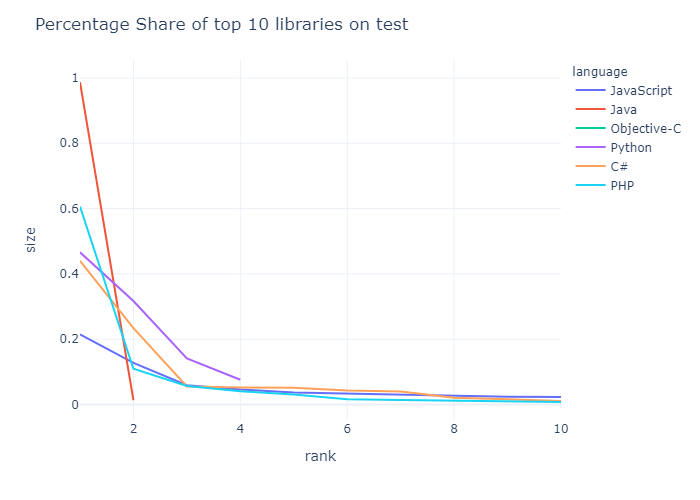

In [57]:
# percentage share distribution for the top libraries, 
# change the key to change the chosen topic 

key='test'

keywords = pd.read_csv("./data/keywords.csv")
chosen = keywords.loc[keywords.apply(lambda row: key in str(row['keywords']), axis=1)].copy()
def normalize_chosen(row):
    norm = chosen.loc[chosen.language == row['language']]['dependent_projects_count'].sum()
    return row['dependent_projects_count'] / (norm + 0.001)
chosen['size'] = chosen.apply(normalize_chosen, axis=1) 

x =   ['JavaScript'] + list(set(top_lang.language.unique()) - {'CSS','HTML', 'JavaScript'})
df = pd.DataFrame()
for lang in x:
    temp = chosen.loc[chosen.language == lang].sort_values('size', ascending=False).head(10)
    temp['rank'] = np.arange(1, len(temp) + 1)
    df = df.append(temp)
fig = px.line(df, x='rank', y='size', color='language', template="plotly_white")
fig.update_layout(title=f"Percentage Share of top 10 libraries on {key}")
display(Image(fig.to_image()))

## 3.3 Twinkling  the Details

Finally, I can knit the figures into a story. For example, I slightly shift the position of the introduction and add a word cloud on the top right. The word cloud is a "glance" of the WebDev world and the developers can be attracted by it. Also, I unify the color and share the legend for some of the figures to make it look nice and precise. Finally, I chose green for the overall color scheme, green is the color of Github's contribution plot. The color hints the open source development community and their contributions to the projects. 

# 4. Reflections and Conclusions

First, the most significant difference for a poster is the amount of explanations and information it can hold. Compare to a data report or a interactive dashboard, a poster contains significantly less information. Most of the information are carried through the figures and the lack of interactivity further limit the amount of information. Therefore, we have to focus on the key ideas and highlight it by size, color, or shape. Such task is quite challenging. 

Also, the targeted audience matters. Because the difference in the audience and the level of background knowledge. A poster will focus less on the technical details and focus more on the appealing visuals. Sometimes, these visuals may not be very statistically useful, but attractive for the audience. 

In addition, Compare to a data analysis or data explorations, the poster is more biased on nature. When I try to convey our audience with the story, I chose clues that are on my side. We choose the data that looks appealing and drop some data that are important but against our story. Although every data analysis will have some degree of bias, the poster is more impacted by these bias due to the targeted audience and limited information it contains. 

In [24]:
# The code below are to create the plots on the poster

In [25]:
# word_count_Q = pd.read_gbq(
#         '''
#         SELECT name_with_owner, stars_count
#         FROM `bigquery-public-data.libraries_io.repositories` 
#         WHERE (language = "JavaScript" 
#                OR language = "TypeScript" 
#                OR language = "CoffeeScript"
#                OR language = "Vue") 
#             AND SOURCERANK > 10
#             AND stars_count > 20
#         ORDER BY sourcerank DESC
#         '''
#     )
# word_count_Q.index = word_count_Q['name_with_owner'].apply(lambda x: x.split("/")[1])
# word_count_Q['stars_count'] = np.log(np.log10(word_count_Q['stars_count']))
# word_count_Q.to_csv("./data/word_count_Q.csv")

In [26]:
# The word cloud on the top right corner of the poster
word_count_Q = pd.read_csv("./data/word_count_Q.csv")
word_count_Q.index = word_count_Q['name_with_owner']
mask = (np.tril(np.ones((800, 800))).repeat(3, axis=1) * 255).astype(np.uint8)
wc = WordCloud(mask=mask, max_words=600, min_font_size=8,
               font_path="Ubuntu-Regular.ttf",
               background_color=None, mode="RGBA")
wc = wc.generate_from_frequencies(word_count_Q.to_dict()['stars_count'], max_font_size=300)

# Uncomment to save and show the WC

# wc.to_file("./plots/word_cloud.png");
# plt.imshow(wc)
# plt.axis("off");

In [27]:
# Plot the cummulative number of projects through time

fig = go.Figure()
i = 0
annotations = []
number_max = time_proj_g['number'].max()
for lang in list(order[:10]):
    time_l = time_proj.loc[time_proj.language == lang]
    color = px.colors.qualitative.Vivid[i]
    fig.add_trace(
        go.Scatter(x = time_l.time, 
                   y=time_l.number.cumsum(), 
                   name=lang, 
                   legendgroup=2 if lang != "JavaScript" else 1,
                   line={'width': 2, 'color': color}
                  )
    )
    annotations.append(dict(xref='paper', 
                            x=0.95, 
                            y=time_l.number.sum(),
                            xanchor='left', 
                            yanchor='middle',
                            text=f'{time_l.number.sum()}',
                            font=dict(size=int(np.sqrt(time_l.number.sum() / number_max) * 20) + 3, 
                                      color=color),
                            showarrow=False)
                      )
    
    i += 1
    
fig.update_layout(template="plotly_white", height=800, width=800, 
                 legend={
                        'x': 1.5,
                        'xanchor': 'left',
                        'y': .85
                        }, 
                  annotations=annotations,
                  font={'size': 16},
                  showlegend=False,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False),
                 )

# save the color so that can be unified for other figures
colors = [data.line.color for data in fig.data]


# fig.show()
# fig.write_image("./plots/time_proj.png")

In [32]:
# creata the bar of market share for each lang
time_proj_pie['color'] = colors[:2] + [colors[-1]] + colors[2:] 
fig = go.Figure()
for lang, row in time_proj_pie[::-1].iterrows():
    fig.add_trace(
        go.Bar(x=[''], y = [row['number'] / time_proj_pie.number.sum() * 100], 
               name=row['language'],
               text=[str(round(row['number'] / time_proj_pie.number.sum() * 100, 1)) + "%"],
               textposition="inside",
               marker_color=row['color'])
    )
fig.update_layout(barmode='stack', 
                  height=800, width=300, 
                  legend={
                        'x': 1.5,
                        'xanchor': 'left',
                        'y': .95
                        }, 
                  showlegend=True, 
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False),
                  template="plotly_white", 
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)');
# fig.write_image("./plots/language_number_bar.png")
# fig.show()

In [33]:
# avg_dependency = pd.read_gbq(
#     '''
#     SELECT language, AVG(dep_n) as avg_dep_count, SUM(DISTINCT project_id)
#     FROM `bigquery-public-data.libraries_io.projects` AS proj JOIN
#       (SELECT project_id, COUNT(DISTINCT dependency_project_id) AS dep_n
#       FROM `bigquery-public-data.libraries_io.dependencies`
#       GROUP BY project_id) AS dep_count
#       ON dep_count.project_id = proj.id
#     WHERE proj.sourcerank > 15
#     GROUP BY language
#     ORDER BY avg_dep_count DESC
#     '''
# )
# avg_dependency.columns = ['language', 'avg_dep', 'number']
# avg_dependency.to_csv("./data/avg_dependency.csv", index=False)

In [37]:
# find the avg_number of dep. for the targeted langs
top_lang['color'] = colors
avg_dependency = pd.read_csv("./data/avg_dependency.csv")
avg_JS = avg_dependency.loc[avg_dependency.language.apply(lambda x: x in JS_based)]
avg_js_sum = sum(avg_JS['avg_dep'] * avg_JS['number'] / avg_JS['number'].sum())
avg_dependency = avg_dependency.set_index('language').drop(JS_based + ['Perl'], axis=0).reset_index()
avg_dependency = avg_dependency.append(pd.DataFrame(
    {
        'language': ['JavaScript'], 
        'avg_dep': [avg_js_sum]
    }
))
avg_dependency = avg_dependency.merge(top_lang[['number', 'color']].reset_index(), on="language")
avg_dependency = avg_dependency.sort_values("avg_dep")

In [38]:
# plot the average numbre of dep.
avg_dependency['avg_dep'] = np.round(avg_dependency['avg_dep'], 2)
fig = px.bar(avg_dependency, 
             y='language', x='avg_dep', 
             orientation="h",
             height=600, width=600, 
             template="plotly_white", 
             text="avg_dep", 
            )
fig.update_layout(coloraxis_showscale=False, 
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False),
                 )
fig.update_xaxes(range=[0, 21])
fig.data[0].marker.color = avg_dependency['color']
fig.layout.xaxis.title.text = "Average Number of dependencies"
# fig.write_image("./plots/average_dep.png")
# fig.show()

In [39]:
# keywords = pd.read_gbq(
#     """
#     SELECT language, name, 
#            keywords, sourcerank, 
#            description, dependent_projects_count 
#     FROM `bigquery-public-data.libraries_io.projects` 
#     WHERE sourcerank > 5
#            AND dependent_projects_count > 10
#     """
# )
# keywords.to_csv("./data/keywords.csv", index=False)

In [40]:
keywords = pd.read_csv("./data/keywords.csv")

In [41]:
import plotly.figure_factory as ff

# create the heatmap for market share of the top libraries on the given simple task
# change key to change the task

key = 'date'
keywords = pd.read_csv("./data/keywords.csv")
chosen = keywords.loc[keywords.apply(lambda row: key in str(row['keywords']), axis=1)]

# normalize the number of dependent projects 
# overall all dependency in this language
# i.e. the market share
def normalize_chosen(row):
    norm = chosen.loc[chosen.language == row['language']]['dependent_projects_count'].sum()
    #  add 0.001 to avoid div by 0
    return row['dependent_projects_count'] / (norm + 0.001)
chosen['size'] = chosen.apply(normalize_chosen, axis=1) 

x =   ['JavaScript']+list(set(top_lang.language.unique()) - {'CSS','HTML', 'JavaScript'})
# to creat the heat matrix
z_matrix = []
z_text = []
for lang in x:
    df = chosen.loc[chosen.language == lang].sort_values('size', ascending=False).head(5)
    if len(df) == 0:
        z_matrix.append([0, 0, 0, 0, 100])
        z_text.append(['0%', '0%', '0%', '0%', 'Std. Lib.<br>100%'])
    else:
        z = list(np.round(df['size'] * 100, 2))
        z += [0] * (5-len(z))
        z = z[::-1]
        z_matrix.append(z)
        z_t = list(df['name'])
        if len(z_t) == 1:
            z_t = ['Std. Lib.']
        z_t += [""] * (5-len(z_t))
        z_t = z_t[::-1]
        z_text.append([f'{text.split("/")[-1]}<br>{number}%' for text, number in zip(z_t, z)])
fig = ff.create_annotated_heatmap(list(map(list, zip(*z_matrix))), 
                                  x=x, 
                                  annotation_text=list(map(list, zip(*z_text))), 
                                  colorscale='Greens')  
fig.update_layout(template="plotly_white",
                  height=480, width=1440,
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  font={'size': 16}
                  )
fig.update_yaxes(showticklabels=False)
fig.update_xaxes(showticklabels=False);
# fig.write_image(f"./plots/kw-{key}.png")
# fig.show()

In [42]:
# community = pd.read_gbq(
#     """
#     SELECT name, 
#            keywords, sourcerank, 
#            description, dependent_projects_count 
#     FROM `bigquery-public-data.libraries_io.projects` 
#     WHERE sourcerank > 5 AND (
#         language = "JavaScript" OR
#         language = "Vue" OR
#         language = "TypeScript"
#     )
#     """
# )
# community.to_csv("./data/community.csv", index=False)

In [43]:
# find the size of community for each popular framework and draw the dot
community = pd.read_csv("./data/community.csv")
brands = ['typescript', 'react', 'jquery', 'vue', 'bootstrap', 'angular', 'ember']
numbers= []
true_numbers = []
for brand in brands:
    chosen = community.loc[community.keywords.apply(lambda x: brand in str(x).lower())]
    true_numbers.append(chosen["dependent_projects_count"].max())
    numbers.append(int(chosen["dependent_projects_count"].max() / community.dependent_projects_count.max() * 200))
    
fig = go.Figure()
fig.add_trace(
    go.Scatter(y=[0] * len(brands), x=brands, 
               marker={'size': numbers, 
                       'color': numbers,
                       'colorscale': 'Oryel'
                      }, 
               mode="markers+text", 
               text=true_numbers,
               textposition="top center"
              )
)

fig.update_yaxes(showticklabels=False, showgrid=False)
fig.update_xaxes(showgrid=False)
fig.update_layout(width=800, height=360, template="plotly_white", 
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)',
                  xaxis=dict(showgrid=False, zeroline=False),
                  yaxis=dict(showgrid=False, zeroline=False),
                  font={'size': 18});
# fig.write_image("./plots/size.png")
# fig.show()

In [44]:
# find the word score and create the word cloud
chosen_wc = community.loc[community.keywords.apply(lambda x: any([b in str(x) for b in brands]))].sort_values("dependent_projects_count", ascending=False).head(20)
wc_list = " ".join(list([x.lower() for x in chosen_wc.description]))
for b in brands + ['javascript', 'npm', 'webpack', 'library', 'node', 'js', 'cli', 'testing', 'package']:
    wc_list = wc_list.replace(b, "")
    
wc = WordCloud(width=800, height=480, max_words=10000, min_font_size=8,
               font_path="Ubuntu-Regular.ttf",
               background_color=None, mode="RGBA")
wc = wc.generate(wc_list)
# wc.to_file("./plots/word_cloud_topics.png");
# plt.imshow(wc)
# plt.axis("off");